# OCC time EDA

EDA en tiempo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
spark = SparkSession \
    .builder \
    .appName("occ_time_eda") \
    .getOrCreate()

#filename = "occ-timeseries.jsonl"
filename = "occ-timeseries-v0.0.2.jsonl" #real: solo vacantes no agregadas

base_dir = f"harvester/occ/"
df = spark.read.json(f"{base_dir}/{filename}")

In [3]:
df.printSchema()

root
 |-- agg: struct (nullable = true)
 |    |-- confidenciales: long (nullable = true)
 |    |-- count_by_category: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- category_id: long (nullable = true)
 |    |    |    |-- count: long (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- pct: double (nullable = true)
 |    |-- count_by_company_url: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- count: long (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |-- count_by_company_where_not_redirected: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- count: long (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |-- count_by_granular_location: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- count: long (nullable

In [4]:
df_c = df.withColumn("day", F.to_date(F.col("date"), "yyyyMMdd"))
df_c.select('day').collect()

[Row(day=datetime.date(2023, 7, 14)),
 Row(day=datetime.date(2023, 7, 24)),
 Row(day=datetime.date(2023, 8, 2)),
 Row(day=datetime.date(2023, 8, 8)),
 Row(day=datetime.date(2023, 8, 21)),
 Row(day=datetime.date(2023, 8, 30)),
 Row(day=datetime.date(2023, 9, 12)),
 Row(day=datetime.date(2023, 9, 20)),
 Row(day=datetime.date(2023, 9, 25)),
 Row(day=datetime.date(2023, 10, 2)),
 Row(day=datetime.date(2023, 10, 10)),
 Row(day=datetime.date(2023, 10, 17)),
 Row(day=datetime.date(2023, 10, 23)),
 Row(day=datetime.date(2023, 10, 30)),
 Row(day=datetime.date(2023, 11, 13)),
 Row(day=datetime.date(2023, 11, 15)),
 Row(day=datetime.date(2023, 11, 17)),
 Row(day=datetime.date(2023, 11, 20)),
 Row(day=datetime.date(2023, 11, 22)),
 Row(day=datetime.date(2023, 11, 24)),
 Row(day=datetime.date(2023, 11, 27)),
 Row(day=datetime.date(2023, 11, 29)),
 Row(day=datetime.date(2023, 12, 1)),
 Row(day=datetime.date(2023, 12, 6)),
 Row(day=datetime.date(2023, 12, 11)),
 Row(day=datetime.date(2023, 12, 20)),


,deduplicated_record_count,deduplicated_record_count_noagg
day,,
2023-07-14,139142,84658
2023-07-24,133901,79659
2023-08-02,129699,78558
2023-08-08,133497,78332
2023-08-21,150500,79529
2023-08-30,149077,79747
2023-09-12,148288,78912
2023-09-20,152239,78338
2023-09-25,152739,78537


<Axes: xlabel='day'>

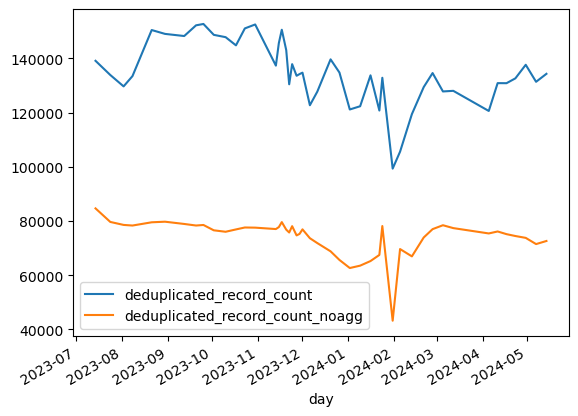

In [5]:
__df_c = df_c.select(["day", "deduplicated_record_count", "deduplicated_record_count_noagg"]).toPandas()
__df_c["day"] = pd.to_datetime(__df_c["day"], format="%Y-%M-%d")
__df_c.set_index("day", inplace=True)
display(__df_c)
__df_c.plot()

In [6]:
__df_c['ratio'] = __df_c['deduplicated_record_count_noagg'] / __df_c['deduplicated_record_count']
__df_c

,deduplicated_record_count,deduplicated_record_count_noagg,ratio
day,,,
2023-07-14,139142,84658,0.608429
2023-07-24,133901,79659,0.594910
2023-08-02,129699,78558,0.605695
2023-08-08,133497,78332,0.586770
2023-08-21,150500,79529,0.528432
2023-08-30,149077,79747,0.534938
2023-09-12,148288,78912,0.532154
2023-09-20,152239,78338,0.514572
2023-09-25,152739,78537,0.514191


<Axes: xlabel='day'>

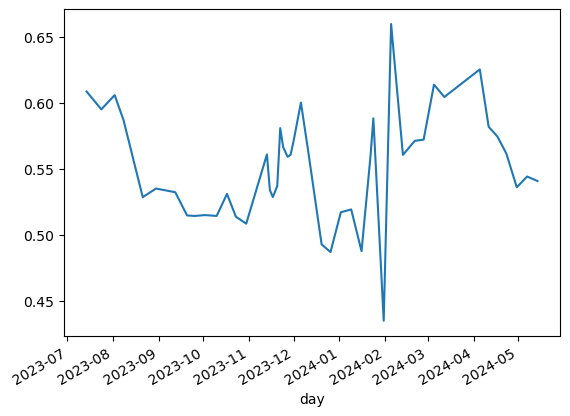

In [7]:
__df_c["ratio"].plot()

In [8]:
def new_jobs(df, date_range, subset="noagg"):
    def date_jobids(date):
        return set(df.filter(df.day == date).select([f'{subset}.jobids']).toPandas()['jobids'][0])
    
    date_range = sorted(date_range)
    s1 = date_jobids(date_range[0]) 
    ret = []
    for i in range(1, len(date_range)):
        s2 = date_jobids(date_range[i])
        ret.append(len(s2 - s1))
        s1 = s2
    return ret

__df_c = df_c.select('day').toPandas()
_dates = list(__df_c['day'])#[14:20]
__df_c["new_jobs"] = [np.nan] + new_jobs(df_c, _dates, "noagg")    
__df_c["new_jobs"]

0         NaN
1     14221.0
2     15845.0
3     10228.0
4     20906.0
5     16278.0
6     20239.0
7     13145.0
8      8025.0
9     11433.0
10    14351.0
11    12560.0
12     9967.0
13    11465.0
14    21314.0
15     5346.0
16     3929.0
17     2836.0
18     3402.0
19     4348.0
20     2583.0
21     4897.0
22     3779.0
23     6556.0
24     5855.0
25    12182.0
26     4684.0
27     6006.0
28    12462.0
29    12894.0
30    10181.0
31    15264.0
32     1823.0
33    31704.0
34    12475.0
35    17617.0
36     9842.0
37    11515.0
38    11890.0
39    33106.0
40    10709.0
41     9510.0
42     9304.0
43    11006.0
44     9966.0
45    12465.0
Name: new_jobs, dtype: float64

In [9]:
__df_c['day_diff'] = __df_c['day'].diff()
__df_c['avg_new_jobs_pd'] = __df_c['new_jobs'] / __df_c['day_diff'].dt.days
__df_c

,day,new_jobs,day_diff,avg_new_jobs_pd
0,2023-07-14,NaN,NaT,NaN
1,2023-07-24,14221.0,10 days,1422.100000
2,2023-08-02,15845.0,9 days,1760.555556
3,2023-08-08,10228.0,6 days,1704.666667
4,2023-08-21,20906.0,13 days,1608.153846
5,2023-08-30,16278.0,9 days,1808.666667
6,2023-09-12,20239.0,13 days,1556.846154
7,2023-09-20,13145.0,8 days,1643.125000
8,2023-09-25,8025.0,5 days,1605.000000
9,2023-10-02,11433.0,7 days,1633.285714


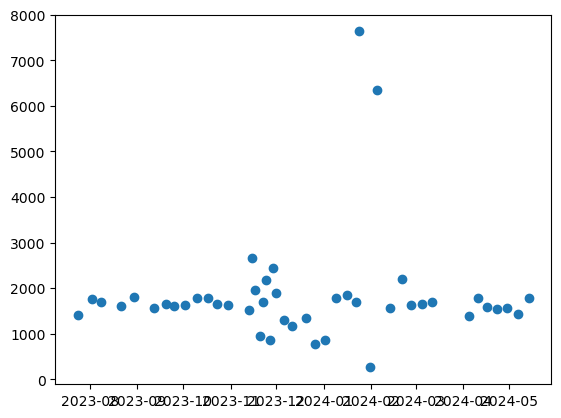

In [10]:
plt.scatter(__df_c['day'], __df_c['avg_new_jobs_pd'])

In [11]:
dfu.groupby("redirect.type").count().show()

NameError: name 'dfu' is not defined

In [ ]:
df.groupby("jobType").count().show()

In [ ]:
dfu.groupby("jobType").count().show()

In [ ]:
dfu.groupby("jobType").pivot("redirect.type").count().show()

#### Proporciones por JobType

In [ ]:
pdf = dfu.groupby("jobType").pivot("redirect.type").count().toPandas().fillna(0).set_index('jobType')
pdf.columns = ['NoRedir', 'Redir1', 'Redir2']
pdf.div(pdf.sum(axis=1), axis=0)

#### Proporciones por tipo de redir

Esto demostraría que las Redir2 son agregadas no pagadas ya que practicamente todas son clásicas

In [ ]:
pdf.div(pdf.sum(axis=0), axis=1)

#### Proporciones del total

In [ ]:
pdf.div(pdf.sum().sum())

### Totales

In [ ]:
cat_count = dfu.groupby("category").count().orderBy(F.col("count").desc())
split_col = F.split(cat_count["category.__ref"].cast("String"), ":")
cat_count = cat_count.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count = cat_count.join(categories.select("id", "description"), cat_count.category_id == categories.id, how="inner")
cat_count = cat_count.select(["category_id", "description", "count"]).orderBy(F.col("count").desc())

In [ ]:
cat_count = cat_count.withColumn("pct", F.col("count") / record_count)
cat_count.show(cat_count.count(), truncate=False)

### Proporciones por tipo de Redir

In [ ]:
split_col = F.split(dfu["category.__ref"].cast("String"), ":")
cat_count_redir = dfu.withColumn("category_id", split_col.getItem(1).cast("INT"))
cat_count_redir = cat_count_redir.groupby("category_id").pivot("redirect.type").count()
cat_count_redir = cat_count_redir.join(categories.select("id", "description"), cat_count_redir.category_id == categories.id, how="inner")
cat_count_redir = cat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
cat_count_redir.columns = ["Category", "NoRedir", "Redir1", "Redir2"]
cat_count_redir = cat_count_redir.set_index("Category")
cat_count_redir = cat_count_redir.div(cat_count_redir.sum(axis=1), axis=0)
cat_count_redir

#### Categorías en las que OCC es débil

Mayor proporción de agregadas

In [ ]:
cat_count_redir.sort_values("Redir2", ascending=False)

In [ ]:
subcat_count = dfu.groupby("subcategory").count().orderBy(F.col("count").desc())
split_col = F.split(subcat_count["subcategory.__ref"].cast("String"), ":")
subcat_count = subcat_count.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count = subcat_count.join(subcategories.select("id", "description"), subcat_count.subcategory_id == subcategories.id, how="inner")
subcat_count.orderBy(F.col("count").desc()).show(25, truncate=False)

In [ ]:
split_col = F.split(dfu["subcategory.__ref"].cast("String"), ":")
subcat_count_redir = dfu.withColumn("subcategory_id", split_col.getItem(1).cast("INT"))
subcat_count_redir = subcat_count_redir.groupby("subcategory_id").pivot("redirect.type").count()
subcat_count_redir = subcat_count_redir.join(subcategories.select("id", "description"), subcat_count_redir.subcategory_id == subcategories.id, how="inner")
subcat_count_redir = subcat_count_redir.select(["description", "0", "1", "2"]).sort(F.col("0").desc()).toPandas().fillna(0)
subcat_count_redir.columns = ["subcategory", "NoRedir", "Redir1", "Redir2"]
subcat_count_redir = subcat_count_redir.set_index("subcategory")
subcat_count_redir = subcat_count_redir.div(subcat_count_redir.sum(axis=1), axis=0)
pd.set_option('display.max_rows', None)
subcat_count_redir

In [ ]:
subcat_count_redir.sort_values("Redir2", ascending=False)

In [ ]:
dfu.groupby("googleForJobs").count().sort(F.col("count").desc()).show(truncate=False)

### Estados

#### Distribución de vacantes por estado con suma acumulada

In [ ]:
dfu_loc = dfu.select("id", F.explode("location.locations").alias("loc_data"))
state_count = dfu_loc.groupby("loc_data.state.description").count().sort(F.col("count").desc())
state_count_p = state_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
state_count_p = state_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
state_count_p.show(33)

#### Vacantes por estado divididas por tipo Redir, con histograma para Redir2

In [ ]:
state_count = dfu.withColumn("loc_data", F.explode("location.locations"))\
                .groupby("loc_data.state.description")\
                .pivot("redirect.type").count()\
                .withColumn("total", F.col("0") + F.col("1") + F.col("2"))\
                .withColumn("NoRedirPct", F.col("0") / F.col("total"))\
                .withColumn("Redir1Pct", F.col("1") / F.col("total"))\
                .withColumn("Redir2Pct", F.col("2") / F.col("total"))\
                .sort(F.col("total").desc())

In [ ]:
state_count.show()

In [ ]:
state_count_pd = state_count.toPandas()
print(state_count_pd["Redir2Pct"].describe())
state_count_pd["Redir2Pct"].hist(bins=15)

#### Descripción (granular)

In [ ]:
loc_count = dfu.groupby("location.description").count().sort(F.col("count").desc())
loc_count_p = loc_count.withColumn("perc", F.col("count") / record_count).orderBy(F.col("perc").desc())
window = Window.orderBy(F.col("perc").desc()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
loc_count_p = loc_count_p.withColumn("cumsum", F.sum(F.col("perc")).over(window))
print(f"Número de location.description: {loc_count_p.count()}")
loc_count_p.show(30, truncate=False)

In [ ]:
loc_count_p.toPandas()["cumsum"].plot()